In [2]:
!pip install optuna

## Part 2. Kaggle dataset

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/company-bankruptcy-prediction/data.csv


### Overview

The dataset contains bankruptcy data from the Taiwan Economic Jouranl for the years 1999-2009. The dataset consists of one csv file that was not changed. It contains 96 attributes one of which is wether a company went bankrupt or not. The dataframe does not contain any null values. The column names where changed to make easier to handle. See dictionary matches for more.

In [4]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
# import warnings
# warnings.filterwarnings("ignore")

url = '/kaggle/input/company-bankruptcy-prediction/data.csv'
df = pd.read_csv(url)

print(df.isnull().values.any())
print(len(df))

False
6819


Rename columns so that they are easier to manipulate. As stated in https://www.kaggle.com/datasets/fedesoriano/company-bankruptcy-prediction

In [5]:
matches = {}
i = 0;
matches["Bankrupt?"] = 'Y'
for col in df.columns:
    if (col != "Bankrupt?"):
        matches[col] = "X"+str(i)
        i+=1
data = df.rename(columns=matches)

Check if some column has the same values if yes drop it

In [6]:
def is_unique(s):
    a = s.to_numpy() # s.values (pandas<0.24)
    return (a[0] == a).all()

for col in data.columns:
    if (is_unique(data[col])):
        data = data.drop(col, axis=1)
data.head()

,Y,X0,X1,X2,X3,X4,X5,X6,X7,X8,...,X84,X85,X86,X87,X88,X89,X90,X91,X92,X94
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,0.035490


In [7]:
labels = data.iloc[:,0]
features = data.drop("Y",axis=1)

In [8]:
ones, zeros = 0,0
for val in data["Y"]:
    if val == 0:
        zeros +=1
    if val == 1:
        ones +=1
print("Class 0 : ", zeros/(zeros+ones),"Class 1 : ", ones/(zeros+ones))

Class 0 :  0.967737204868749 Class 1 :  0.03226279513125092


## Out of the box MLP and SVM

In [9]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

train, test, train_labels, test_labels = train_test_split(features.values, labels.values, test_size = 0.3)

clf = MLPClassifier()
clf.fit(train, train_labels)
mlp_predictions = clf.predict(test)
f1_mlp = f1_score(test_labels, mlp_predictions, average = "macro")
accuracy_mlp = accuracy_score(test_labels, mlp_predictions)

svm = SVC()
svm.fit(train, train_labels)
svm_predictions = svm.predict(test)
f1_svm = f1_score(test_labels, svm_predictions, average = "macro")
accuracy_svm = accuracy_score(test_labels, svm_predictions)

print("F1 for mlp: ", f1_mlp, "F1 for svm: ", f1_svm)
print("Accuracy for mlp: ", accuracy_mlp, "Accuracy for svm: ", accuracy_svm)

F1 for mlp:  0.49818066663355026 F1 for svm:  0.49066467513069456
Accuracy for mlp:  0.9227761485826002 Accuracy for svm:  0.9633431085043989


### What metric should we use?

In the above two code cells we can see that F1 is a much better metric for our dataframe since we have class imbalance: 96 % of the given samples have not gone bankrupt and only a mere 4 % have. This means that a dummy classifier could achieve 96% accuracy. However by considering the percision and recal in the F1 metric we realise that in reality our out of the box Classifiers are not that percise.
For this reason we will proceed this work considering the **F1 metric**

### Should we use Cross-validation?

Due to the large amount of data and to the fact tha cross-validation is computationaly demanding and therfore time consuming we did not use cross-validation.

### Metric results

               MLP       SVM
F1 score  0.498181  0.490665


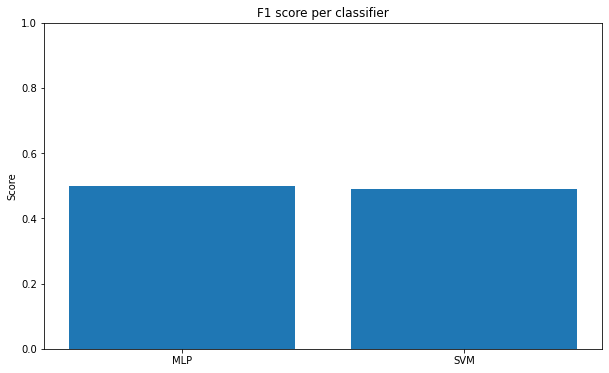

In [10]:
data = {"MLP": f1_mlp, "SVM": f1_svm}
print(pd.DataFrame(data = data,index = ["F1 score"]))

plt.figure(figsize = (10,6))
plt.bar(data.keys(), data.values())
plt.ylim(0.0,1.0)
plt.ylabel("Score")
plt.title('F1 score per classifier')
plt.show()

### Observations

Both classifiers have similar score close to 0.5 which is very low.

## Optimization

In [11]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler ,Normalizer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA

predictions = {}
def objective_mlp(trial):
    
    # Preprocessing (scale and select)
    scaler_option = trial.suggest_categorical("scaler", ["StandardScaler", "Normalizer"])    
        
    # MLP Hypermarameters
    hidden_layer_sizes = trial.suggest_categorical("hidden_layer_sizes", tuple([(30,),(62,), (50,), (75,), (100,), (200,), (50,100,), (100,50,), (62, 50), (50, 62), (62, 62)]))
    #alpha = trial.suggest_categorical("alphafloat", [0.00005, 0.0001, 0.0002])
    activation = trial.suggest_categorical("activation", ["identity", "logistic", "tanh", "relu"])
    solver = trial.suggest_categorical("solver", ["lbfgs", "sgd", "adam"])
    #shuffle = trial.suggest_categorical("shuffle", [True, False])
    learning_rate = trial.suggest_categorical("learning_rate", ["constant", "invscaling", "adaptive"])
    #max_iter = trial.suggest_categorical("max_iter", [100, 200, 300])
    tol = trial.suggest_categorical("tol", [1e-3, 1e-4, 1e-5])
    #early_stopping = trial.suggest_categorical("early_stopping", [False, True])
    n_iter_no_change = trial.suggest_categorical("n_iter_no_change", [5, 10, 15])
    momentum = trial.suggest_categorical("momentum", [0.85, 0.9, 0.95])
    #validation_fraction = trial.suggest_categorical("validation_fraction", [0.05, 0.1, 0.15])
    
    # PCA components
    n_components = trial.suggest_int("n_components", 10, 94)
    
    # Pipeline
    pipeline = Pipeline(steps = [
        ("sampler", RandomOverSampler()), # over-sample the minority class(es)
        ("selector" , VarianceThreshold()),
        ("scaler", StandardScaler () if scaler_option == "StandardScaler" else Normalizer()),
        ("pca", PCA(n_components = n_components)),
        ("mlp", MLPClassifier(hidden_layer_sizes = hidden_layer_sizes, 
                        #alpha = alpha,
                        activation = activation, 
                        solver = solver, 
                        learning_rate = learning_rate, 
                        #max_iter = max_iter, 
                        tol = tol,
                        #shuffle = shuffle,
                        momentum = momentum,
                        #early_stopping = early_stopping, 
                        n_iter_no_change = n_iter_no_change))
    ])
    
    # Fit and predict
    pipeline.fit(train, train_labels)
    predictions["MLP Opt"] = pipeline.predict(test)
    return f1_score(test_labels, predictions["MLP Opt"], average = "macro")

In [12]:
import optuna
import warnings
warnings.filterwarnings('ignore')

study_mlp = optuna.create_study(direction = 'maximize')

# start tuning for the hyper-parameters
study_mlp.optimize(objective_mlp, n_trials = 50)

[I 2022-12-06 15:29:32,735] A new study created in memory with name: no-name-72e6b0ce-a56e-4b34-bf14-d03a5c914f87
[I 2022-12-06 15:29:35,507] Trial 0 finished with value: 0.03536067892503537 and parameters: {'scaler': 'Normalizer', 'hidden_layer_sizes': (62, 50), 'activation': 'logistic', 'solver': 'sgd', 'learning_rate': 'constant', 'tol': 0.0001, 'n_iter_no_change': 15, 'momentum': 0.95, 'n_components': 47}. Best is trial 0 with value: 0.03536067892503537.
[I 2022-12-06 15:29:38,391] Trial 1 finished with value: 0.6464019356296778 and parameters: {'scaler': 'StandardScaler', 'hidden_layer_sizes': (62,), 'activation': 'tanh', 'solver': 'lbfgs', 'learning_rate': 'adaptive', 'tol': 1e-05, 'n_iter_no_change': 5, 'momentum': 0.85, 'n_components': 73}. Best is trial 1 with value: 0.6464019356296778.
[I 2022-12-06 15:30:00,642] Trial 2 finished with value: 0.5053236699964357 and parameters: {'scaler': 'Normalizer', 'hidden_layer_sizes': (62, 50), 'activation': 'tanh', 'solver': 'lbfgs', 'le

In [13]:
print("The best f1 value for MLP is: ", study_mlp.best_trial.value, "with parameters: ", study_mlp.best_trial.params)

The best f1 value for MLP is:  0.6910632239694557 with parameters:  {'scaler': 'StandardScaler', 'hidden_layer_sizes': (100,), 'activation': 'tanh', 'solver': 'adam', 'learning_rate': 'adaptive', 'tol': 1e-05, 'n_iter_no_change': 10, 'momentum': 0.85, 'n_components': 77}


### Observations and explanation for MLP

In the above cells we aim to optimise the MLP classifier as for the f1 metric. As noted above the f1 score for the out of the box MLP was around 0.5 while after optimizing the metric is around 0.7 (for accurate values look at the cells above). We achieved that by defining a pipeline to automate the workflow: 
1. Sample the data with RandomOverSampling to over-sample the minority class(es) by picking samples at random with replacement.
2. Choose a scaler to preprocess the dataframe and scale our data. As we can see the selection of scaler is very importnant.
3. Choose number of components for PCA. We see that this decision is important for our result and that most of the attributes are significant.
4. Choose values for MLP hyperparameters. As we can see some parameters have a noteworthy impact on our metics whereas others don't. The best hyperparameters are shown above. One hidden layer with less neurons than the input layer usualy has decent results. Many other hypermarameters were used to optimize, however most of them did not have a significant impact on our score.

In [14]:
fig = optuna.visualization.plot_param_importances(study_mlp)
fig.show()

In [15]:
fig = optuna.visualization.plot_slice(study_mlp)
fig.show()

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit
ratio = 0.5
N = int(len(labels.values) * ratio)
sss = StratifiedShuffleSplit(n_splits = 1, test_size = int(0.3 * N), train_size = int(0.7 * N), random_state = 0)

for train_index, test_index in sss.split(features.values, labels.values):
    train_sss, test_sss = features.values[train_index], features.values[test_index]
    train_labels_sss, test_labels_sss = labels.values[train_index], labels.values[test_index]

In [17]:
def objective_svm(trial):
    
    # Preprocessing (scale and select)
    scaler_option = trial.suggest_categorical("scaler", ["StandardScaler", "Normalizer"])    
        
    # SVM Hypermarameters
    C = trial.suggest_loguniform("C", 1E-3, 1E3)
    kernel = trial.suggest_categorical("kernel", ["poly","linear","rbf","sigmoid"])
    degree = trial.suggest_int("degree", 1, 10)
    coef0 = trial.suggest_loguniform("coef0", 1E-2, 1E2)
    tol = trial.suggest_categorical("tol", [1e-2, 1e-3, 1e-4, 1e-5])
    max_iter = trial.suggest_categorical("max_iter", [-1,10,1000,10000,100000])
    
    #PCA n_components
    n_components = trial.suggest_int("n_components", 10, 94)
    
    # Pipeline
    pipeline = Pipeline(steps = [
        ("sampler", RandomOverSampler()), # over-sample the minority class(es)
        ("selector" , VarianceThreshold()),
        ("scaler", StandardScaler () if scaler_option == "StandardScaler" else Normalizer()),
        ("pca", PCA(n_components = n_components)),
        ("svm", SVC(C = C, 
                    kernel = kernel, 
                    degree = degree, 
                    coef0 = coef0,
                    tol = tol,
                    max_iter = max_iter
                   )
)
    ])
    
    
    # Fit and predict
    pipeline.fit(train_sss, train_labels_sss)
    predictions["SVM Opt"] = pipeline.predict(test_sss)
    return f1_score(test_labels_sss, predictions["SVM Opt"], average = "macro")

In [18]:
import optuna
import warnings
warnings.filterwarnings('ignore')

study_svm = optuna.create_study(direction = 'maximize')

# start tuning for the hyper-parameters
study_svm.optimize(objective_svm, n_trials = 50)

[I 2022-12-06 15:39:04,668] A new study created in memory with name: no-name-51701008-5907-4d59-b07a-041c4c3d3c57
[I 2022-12-06 15:39:06,548] Trial 0 finished with value: 0.5031302775455895 and parameters: {'scaler': 'Normalizer', 'C': 353.1407682569845, 'kernel': 'rbf', 'degree': 6, 'coef0': 0.03288235592297339, 'tol': 0.001, 'max_iter': -1, 'n_components': 69}. Best is trial 0 with value: 0.5031302775455895.
[I 2022-12-06 15:39:07,170] Trial 1 finished with value: 0.46201814058956914 and parameters: {'scaler': 'StandardScaler', 'C': 13.746153300785783, 'kernel': 'linear', 'degree': 6, 'coef0': 0.04962977730226578, 'tol': 0.001, 'max_iter': 10000, 'n_components': 84}. Best is trial 0 with value: 0.5031302775455895.
[I 2022-12-06 15:39:10,862] Trial 2 finished with value: 0.4529128778105984 and parameters: {'scaler': 'Normalizer', 'C': 88.04762961282758, 'kernel': 'linear', 'degree': 9, 'coef0': 0.04201622082061833, 'tol': 0.001, 'max_iter': 100000, 'n_components': 73}. Best is trial 0

In [19]:
print("The best f1 value for SVM is: ", study_svm.best_trial.value, "with parameters: ", study_svm.best_trial.params)

The best f1 value for SVM is:  0.6797675147300063 with parameters:  {'scaler': 'StandardScaler', 'C': 3.6024533467835917, 'kernel': 'rbf', 'degree': 8, 'coef0': 44.3730118459714, 'tol': 0.01, 'max_iter': -1, 'n_components': 86}


In [20]:
fig = optuna.visualization.plot_param_importances(study_svm)
fig.show()

In [21]:
fig = optuna.visualization.plot_slice(study_svm)
fig.show()

### Observations and explanation for SVM

It should be noted here that we smpled the dataset to 50% due to the huge amount of smaples. We followed a similar aproach to that of MLP, namely constructing a pipeline and optimizing with optuna.
* Again we can see that the Normalizer although yields some good results is not prefered for the optimization. The choice of scaler is not as important here as it was in the MLP optimization.
* A value of -1 (no limit) and 100k seems to be preferable for the max_iter hyperparameter.
* The best kernel seems to be th "poly".
* Values around 60 for n_components 


### Documentation of the process

As mentioned above we choose hyperparameters with values either all of them if they are descrete or around their default values and some significantly greater or smaller than their default. Some hyperparameters did not have much effect on the objective value so we decided not to inspect them in optuna. After optuna gave us the parameter results we tried for the hyperparameters values around the optimal, to see if we can achieve further optimization. After the optimization we proceeded to plot some graphs related to the significance of each parameter and their relationship as slice plot, so that the process is less of a black box.

### Visualisation of the proccess

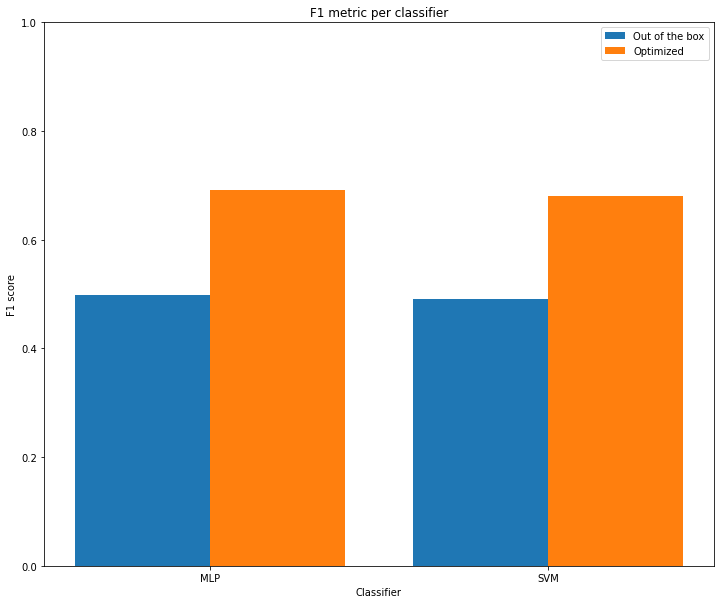

In [28]:
X = ['MLP','SVM']
ootb = [data["MLP"],data["SVM"]]
opt = [study_mlp.best_trial.value,study_svm.best_trial.value]
  
X_axis = np.arange(len(X))

plt.figure(1, figsize = (12,10))
plt.bar(X_axis - 0.2, ootb, 0.4, label = 'Out of the box')
plt.bar(X_axis + 0.2, opt, 0.4, label = 'Optimized')

plt.ylim((0,1))
plt.xticks(X_axis, X)
plt.xlabel("Classifier")
plt.ylabel("F1 score")
plt.title("F1 metric per classifier")
plt.legend()
plt.show()

### Conclusion

For this dataset the two classifiers yield close results. Both out of the box and optimized MLP have a better F1 score than the corresponding SVMs. Since the MLP takes significantly less time to run (we had to ratio the data for SVM) we would choose this classifier for the purposes of predicting wether a company would go bankrupt given this dataset. We also noticed that our dataset was severely imbalanced and therefore had to oversample the minority class (the companies that went bankrupt). We couldn't achieve a f1 score above 0.71, perhaps due to the small amount of data concerning bankrupt companies in this dataset.